In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set(style="darkgrid")

from functions import (get_df_with_return, 
                       get_df_with_mean_std_return,
                       get_portfolio_risk,
                       minimize_portfolio,
                       calculate_efficient_frontier,
                       plot_efficient_frontier)

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [15]:
history_data = pd.read_csv('data/prepared_data.csv', encoding='utf-16')
index_data = pd.read_csv('data/index_data.csv', encoding='utf-16')
stock_characteristics = pd.read_csv('data/data_characteristics.csv', encoding='utf-16').set_index('SECID')
stock_return = pd.read_csv('data/return_data.csv', encoding='utf-16', index_col=0)

In [502]:
stock_characteristics['RISK_FEE'] = stock_characteristics.MEAN_RETURN / stock_characteristics.STD_RETURN
top_10_by_risk_fee = stock_characteristics.sort_values(by='RISK_FEE', ascending=False).head(10).index
stock_characteristics = stock_characteristics.filter(top_10_by_risk_fee, axis=0)
stock_return = stock_return[top_10_by_risk_fee]

In [460]:
index_data_with_return = get_df_with_return(index_data, price_name='CLOSE', first_day_value=0.0)
index_data_characteristics = get_df_with_mean_std_return(index_data_with_return[['SECID', 'RETURN']].copy()).groupby('SECID').first().reset_index().drop(columns=['RETURN'])
index_return = index_data_with_return.RETURN
index_mean_return = index_data_characteristics.MEAN_RETURN[0]
index_std_return = index_data_characteristics.STD_RETURN[0]

# One factor model

In [407]:
from sklearn.linear_model import LinearRegression

def get_alpha_beta(stock_return, index_return):
    
        alpha_vec = []
        beta_mat = []
        stocks_num = stock_return.shape[1]
        reg = LinearRegression()
        
        for i in range(0, stocks_num):
    
            reg.fit(np.array(index_return).reshape(len(stock_return), 1),
                    np.array(stock_return.iloc[:, i]).reshape(len(stock_return), 1))
            
            alpha_vec.append(reg.intercept_[0])
            beta_mat.append(reg.coef_[0,0])

        alpha_vec = np.array(alpha_vec)
        beta_mat = np.array(beta_mat)
                
        return alpha_vec, beta_mat

In [380]:
def get_estimations(stock_characteristics, index_return, alpha, beta):
    linear_stocks_mean_return = []
    linear_stocks_std_return = []
    linear_stocks_mean_noise = []
    linear_stocks_var_noise = []
    noise_matrix = []

    for i in range(stock_return.shape[1]):
        estimated_mean_returns = alpha[i] + beta[i] * index_return
        noises = estimated_mean_returns - stock_return.iloc[:, i].values
        noise_matrix.append(noises.to_list())
        linear_stocks_mean_return.append(estimated_mean_returns.mean())
        linear_stocks_mean_noise.append(noises.mean())
        linear_stocks_var_noise.append(noises.var()) 
        linear_stocks_std_return.append(np.sqrt(np.var(index_return) * beta[i]**2 + noises.var())[0])
        
    sharp_ratio = np.divide(linear_stocks_mean_return, linear_stocks_std_return)
    stock_characteristics_estimated = pd.DataFrame(data={'SECID' : stock_characteristics.index, 
                                                    'MEAN_RETURN' : linear_stocks_mean_return,
                                                    'STD_RETURN' : linear_stocks_std_return,
                                                    'SHARP_RATIO' : sharp_ratio,
                                                    'MEAN_NOISE' : linear_stocks_mean_noise,
                                                    'VAR_NOISE' : linear_stocks_var_noise})
    return stock_characteristics_estimated, noise_matrix

In [381]:
alpha, beta = get_alpha_beta(stock_return, index_return)
    
stock_characteristics_estimated, noise_matrix = get_estimations(stock_characteristics, index_return, alpha, beta)

cov_matrix = get_covariation(beta, stock_characteristics_estimated.VAR_NOISE, index_return)

Проверим применимость модели к рынку.\
Видно, что мат.ожидание шума на всех активах очень близко к нулю, предположение однофакторной модели о нулевом мат.ожидании выполняется.

In [503]:
stock_characteristics_estimated

,SECID,MEAN_RETURN,STD_RETURN,SHARP_RATIO,MEAN_NOISE,VAR_NOISE
0,NVTK,0.001920,0.017301,0.110975,2.458663e-19,0.000205
1,NKNCP,0.001392,0.013119,0.106140,3.278218e-19,0.000157
2,AGRO,0.001292,0.012207,0.105882,1.639109e-19,0.000132
3,TATN,0.001638,0.015589,0.105048,-4.370957e-19,0.000152
4,LKOH,0.001491,0.015891,0.093838,3.414810e-19,0.000112
5,ROSN,0.001467,0.015937,0.092061,3.278218e-19,0.000153
6,SIBN,0.001407,0.015439,0.091154,1.639109e-19,0.000192
7,SNGSP,0.001268,0.014447,0.087791,1.639109e-19,0.000166
8,TATNP,0.001380,0.016239,0.084951,1.092739e-19,0.000231
9,AKRN,0.000713,0.008924,0.079869,0.000000e+00,0.000071


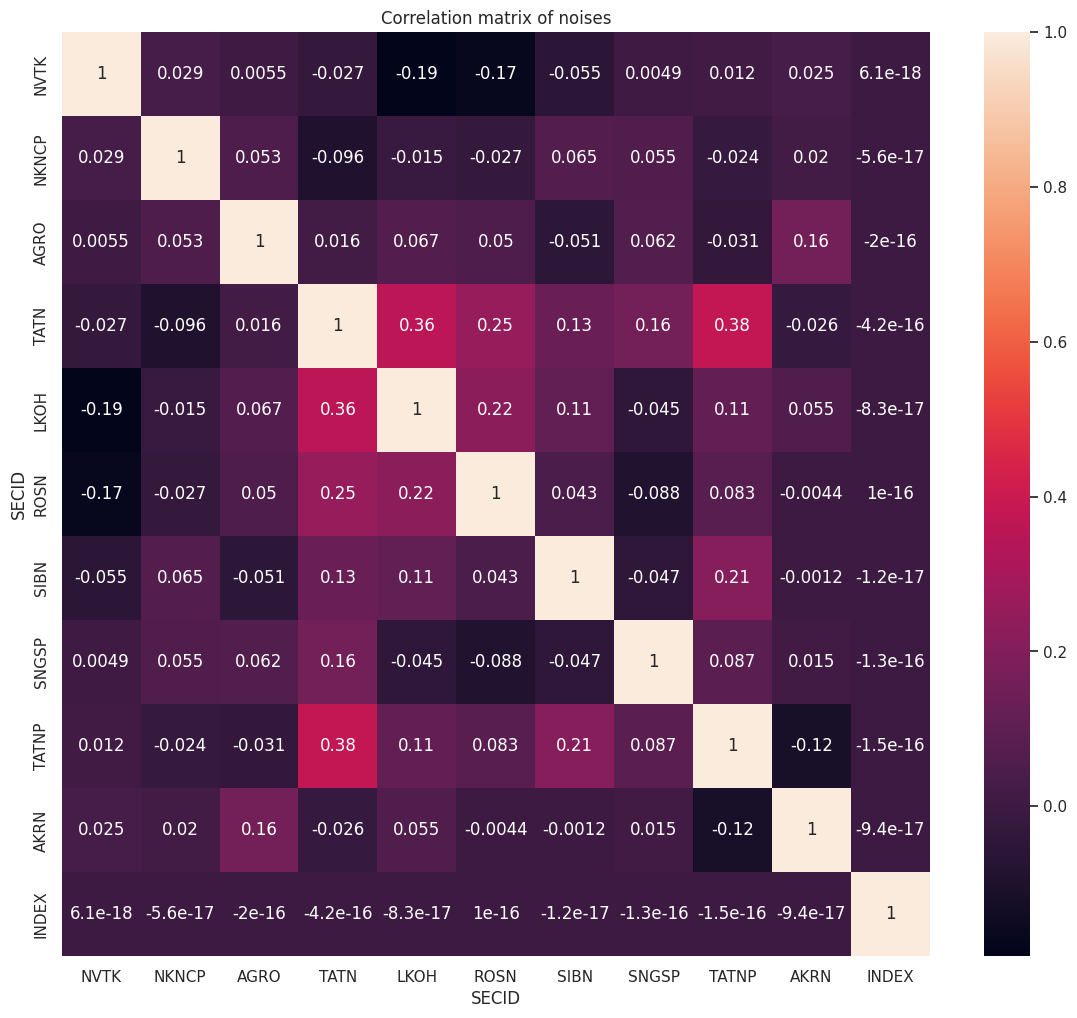

In [548]:
m = pd.DataFrame(np.array(noise_matrix).T, columns=stock_characteristics.index)
m['INDEX'] = index_return
plt.figure(figsize=(14, 12))
sns.heatmap(m.corr(), annot = True)
plt.title('Correlation matrix of noises')
plt.show()

Условие отсутствия попарной корреляции шумов не выполняется: большая часть корреляций относительно близки к нулю, но есть исключения.\
Однако выполняется условие отсутствия попарной корреляции доходности индекса(фактора) и шума. Проверим модель на практике.

In [463]:
def get_optimal_portfolio(stock_characteristics_estimated, beta, index_std_return):
    numerator = (index_std_return**2) * np.sum(beta * stock_characteristics_estimated.MEAN_RETURN / stock_characteristics_estimated.VAR_NOISE)
    denominator = 1 + (index_std_return**2) * np.sum(beta**2 / stock_characteristics_estimated.VAR_NOISE)
    A = numerator / denominator

    x = ((stock_characteristics_estimated.MEAN_RETURN / beta) - A) * beta / stock_characteristics_estimated.STD_RETURN
    x = x / np.sum(x)
    return x

def get_covariation(beta, linear_stocks_square_noise, index_return): 
    return np.diag((beta.T @ beta).item() * np.var(index_return) + np.array(linear_stocks_square_noise))

In [627]:
opt_portfolio = get_optimal_portfolio(stock_characteristics_estimated, beta, index_std_return)
opt_portfolio_mean = np.dot(opt_portfolio, stock_characteristics.MEAN_RETURN)
opt_portfolio_std = get_portfolio_risk(opt_portfolio, stock_return.cov())

In [537]:
result = pd.DataFrame({'SECID' : stock_characteristics.index, 'weights' : opt_portfolio})
display(result.T)

,0,1,2,3,4,5,6,7,8,9
SECID,NVTK,NKNCP,AGRO,TATN,LKOH,ROSN,SIBN,SNGSP,TATNP,AKRN
weights,0.110776,0.218971,0.196772,0.068427,-0.031635,0.015612,0.100559,0.084226,0.121025,0.115266


In [498]:
min_risk_portfolio_std_with_short, min_risk_portfolio_return_with_short, portfolio_stds_with_short, portfolio_returns_with_short = calculate_efficient_frontier(stock_characteristics,
                                                                                                                    stock_return.cov(),
                                                                                                                    short_sales=True)

In [499]:
markowitz_portfolio_with_short = np.array([0.125561, 0.211534, 0.209409, 0.073487, -0.069671, 0.053796, 0.089291, 0.062744, 0.088052, 0.155797])
markowitz_mean_with_short = np.dot(markowitz_portfolio_with_short, stock_characteristics.MEAN_RETURN)
markowitz_std_with_short = get_portfolio_risk(markowitz_portfolio_with_short, stock_return.cov())

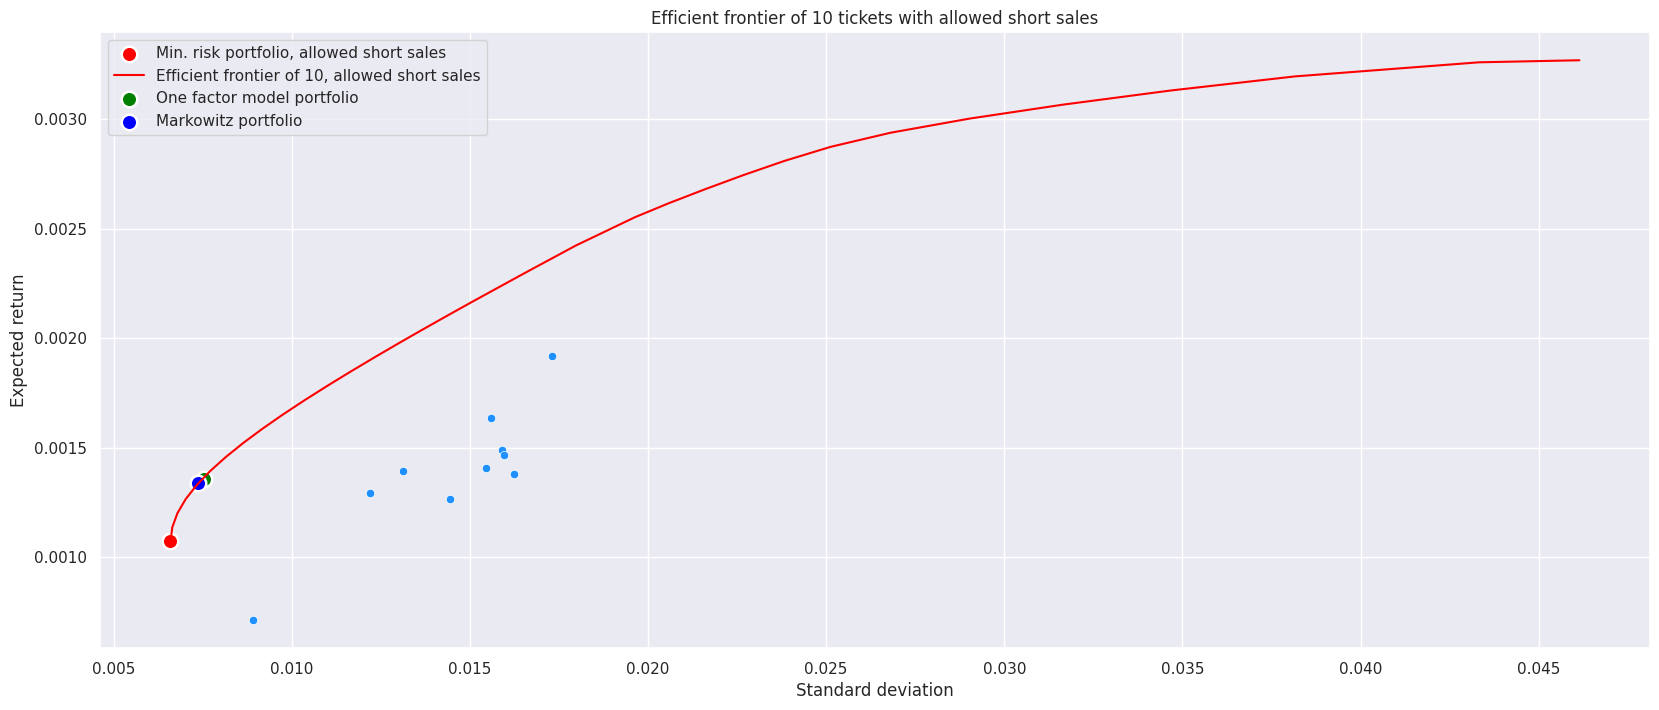

In [500]:
plt.figure(figsize=(20,8))
plot_efficient_frontier(stock_characteristics, 
                        min_risk_portfolio_std_with_short, min_risk_portfolio_return_with_short, portfolio_stds_with_short, portfolio_returns_with_short,
                        short_sales=True)
sns.scatterplot(x=[opt_portfolio_std], y=[opt_portfolio_mean], marker='.', s=500, label='One factor model portfolio', color='green')
sns.scatterplot(x=[markowitz_std_with_short], y=[markowitz_mean_with_short], marker='.', s=500, label='Markowitz portfolio', color='blue')
plt.title('Efficient frontier of 10 tickets with allowed short sales')
plt.show()

В случае с разрешением коротких продаж оптимальный портфель, полученный с помощью однофакторной модели, попадает на эффективный фронт.

In [494]:
markowitz_portfolio = np.array([0.12262, 0.21493, 0.201479, 0.040556, 0.0, 0.035439, 0.087465, 0.066603, 0.088882, 0.142026])
markowitz_mean = np.dot(markowitz_portfolio, stock_characteristics.MEAN_RETURN)
markowitz_std = get_portfolio_risk(markowitz_portfolio, stock_return.cov())

In [492]:
min_risk_portfolio_std, min_risk_portfolio_return, portfolio_stds, portfolio_returns = calculate_efficient_frontier(stock_characteristics,
                                                                                                                    stock_return.cov(),
                                                                                                                    short_sales=False)

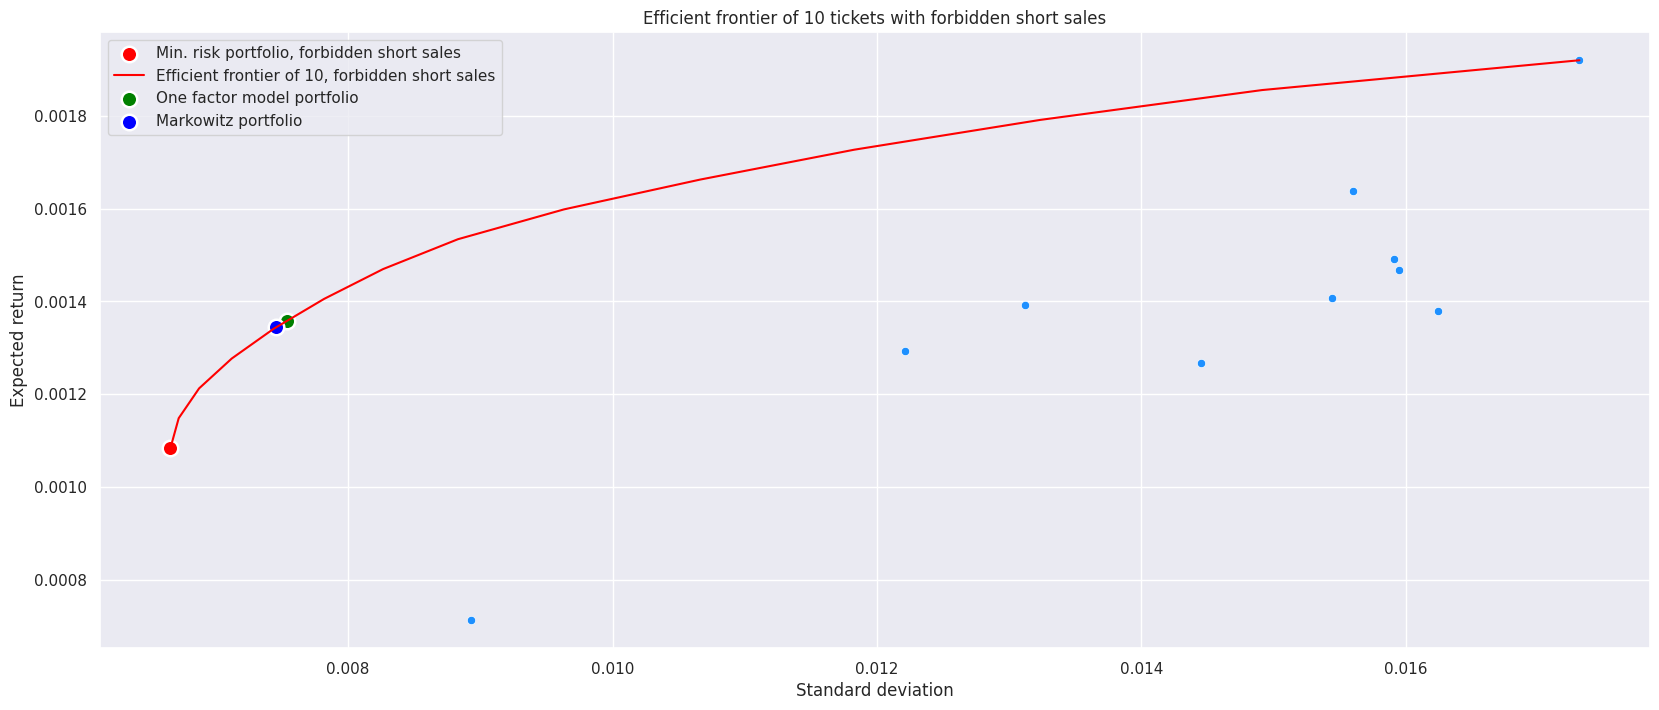

In [496]:
plt.figure(figsize=(20,8))
plot_efficient_frontier(stock_characteristics, min_risk_portfolio_std, min_risk_portfolio_return, portfolio_stds, portfolio_returns, short_sales=False)
sns.scatterplot(x=[opt_portfolio_std], y=[opt_portfolio_mean], marker='.', s=500, label='One factor model portfolio', color='green')
sns.scatterplot(x=[markowitz_std], y=[markowitz_mean], marker='.', s=500, label='Markowitz portfolio', color='blue')
plt.title('Efficient frontier of 10 tickets with forbidden short sales')
plt.show()

В общем случае аналитически нельзя получить оптимальный портфель по однофакторной модели, но в рассматриваемом случае все доли положительные, а эффективные фронты при запрете и разрешении коротких продаж практически совпадают в начале, поэтому и в случае коротких продаж портфель попал на эффективный фронт.

# Задание 6

Составим матрицу для проверки арбитражных возможностей.

In [553]:
matrix = pd.DataFrame({'E' : stock_characteristics_estimated.MEAN_RETURN,
              '1' : np.ones((len(beta),)),
              'beta' : beta})

matrix

,E,1,beta
0,0.001920,1.0,0.900237
1,0.001392,1.0,0.354608
2,0.001292,1.0,0.382360
3,0.001638,1.0,0.882077
4,0.001491,1.0,1.099721
5,0.001467,1.0,0.932457
6,0.001407,1.0,0.630131
7,0.001268,1.0,0.604586
8,0.001380,1.0,0.528478
9,0.000713,1.0,0.270402


Если посчитать ранг полученной матрицы, то получим 3, что соответствует наличию арбитража. Однако, если посчитаем сингулярные числа матрицы, то увидим, что третье значение близко к нулю, что означает слабый арбитраж.

In [555]:
np.linalg.matrix_rank(matrix)

3

In [625]:
singular_values = np.linalg.svd(matrix).S
print(singular_values[0], singular_values[1], singular_values[2], sep='\n')

3.815917010375182
0.7022009139506368
0.0006530945141552352
